In [1]:
import numpy as np
import json
import argparse
from torch.utils.data import DataLoader
from datasets.dl import GeMData
import torch
import os
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import collections
import pandas as pd

In [2]:
class cf:
    def __init__(self):
        self.dpath="ir"
        self.batch_size=1024
        self.k=19
        self.to_valid="valid_for_test.npy"
        self.to_test="test_masked.npy"
        self.test_matrix="tdatabase.npy"
args = cf()

In [3]:
dbp = os.path.join(args.dpath, "database.npy")
testp = os.path.join(args.dpath, args.to_test)
validp = os.path.join(args.dpath, args.to_valid)
imagep = os.path.join(args.dpath, args.test_matrix)
classp = os.path.join(args.dpath, "model_num.json")
resp = os.path.join(args.dpath, "mAP.json")
validip = os.path.join(args.dpath, "imageset.npy")
testip = os.path.join(args.dpath, "test_image.npy")
indexinfop = os.path.join(args.dpath, "indexinfo.csv")
mask2p = os.path.join(args.dpath, "mask2.npy")

In [4]:
print('load data')
md = json.load(open(classp, "r"))
m2 = torch.LongTensor(np.load(mask2p)).to(0)
fdf = pd.read_csv(indexinfop)

test_imm = torch.FloatTensor(np.load(imagep)).to(0)
valid_imm = torch.FloatTensor(np.load(dbp)).to(0)

testset = np.load(testp)
validset = np.load(validp)

db_tensor = valid_imm.transpose(1, 0).to(0)

load data


In [5]:
vdict = {}
for pic_index, carm_index in fdf.values:
    vdict[pic_index] = carm_index
tdict = {}
for pic_index, carm_index in testset:
    tdict[pic_index] = carm_index

In [6]:
validi = np.load(validip).transpose(0, 2, 3, 1)
testi = np.load(testip).transpose(0, 2, 3, 1)

In [7]:
idxset = set(validset[:, 0])
mask = np.ones((1, valid_imm.size(0)))
for i in range(valid_imm.size(0)):
    if i in idxset:
        mask[0, i] = 0
mask = torch.LongTensor(mask).to(0)

In [8]:
testset_inverse = collections.defaultdict(list)
for testid, cm in testset:
    testset_inverse[cm].append(testid)

In [9]:
validset_inverse = collections.defaultdict(list)
for validid, cm in validset:
    validset_inverse[cm].append(validid)

In [10]:
a = set(testset_inverse.keys())
b = set(validset_inverse.keys())
c = a & b
d = a | b
len(c) / len(d)

0.2933070866141732

In [11]:
interlist = list(c)

In [12]:
def show_retrieved_query(cur_idx, isValid=False):
    if isValid:
        cur_cm = vdict[cur_idx]
        curm = valid_imm
        curi = validi
    else:
        cur_cm = tdict[cur_idx]
        curm = test_imm
        curi = testi
    
    cur_score = torch.matmul(curm[cur_idx], db_tensor)
    if isValid:
        cur_score = (cur_score * mask * m2).reshape(-1)
    else:
        cur_score = (cur_score * m2).reshape(-1)
    _, topk = torch.topk(cur_score, args.k)
    topkl = topk.cpu().numpy()
    topk_imgs = validi[topkl]
    label_list = [cur_idx] + topkl.tolist()
    print(label_list)
    label_list = [x in md[str(cur_cm)] for x in label_list]
    final_imgs = np.concatenate([curi[cur_idx].reshape(1, 224, 224, 3), topk_imgs], axis=0)
    f, axarr = plt.subplots(4, 5, figsize=(20, 20))
    print(label_list)
    for i in range(4):
        for j in range(5):
            cur_idx = i * 5 + j
            axarr[i][j].imshow(final_imgs[cur_idx])
            axarr[i][j].title.set_text("label: {}".format(label_list[cur_idx]))
            if cur_idx == 0:
                axarr[i][j].title.set_text("origin query")
    plt.show()

[38895, 38897, 38863, 7415, 7408, 7405, 38868, 38860, 38858, 7404, 7413, 7407, 7409, 38859, 38899, 7414, 38882, 7411, 7418, 38884]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


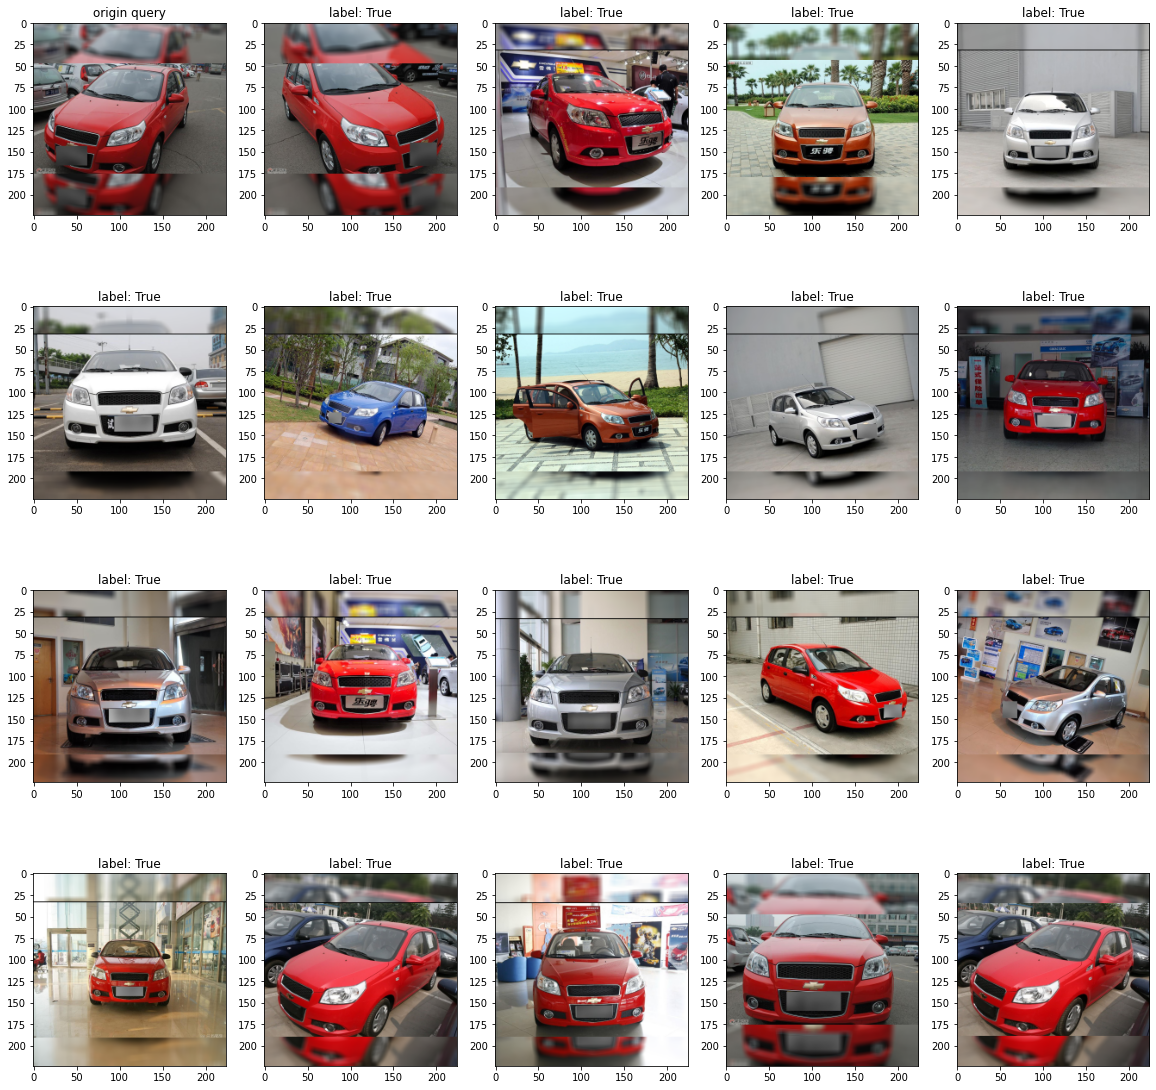

In [13]:
show_retrieved_query(38895, isValid=True)

[15881, 8118, 41003, 40893, 41018, 41017, 41013, 41009, 40988, 41001, 41000, 41010, 40982, 40985, 8120, 40991, 40885, 40987, 40999, 8084]
[False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False]


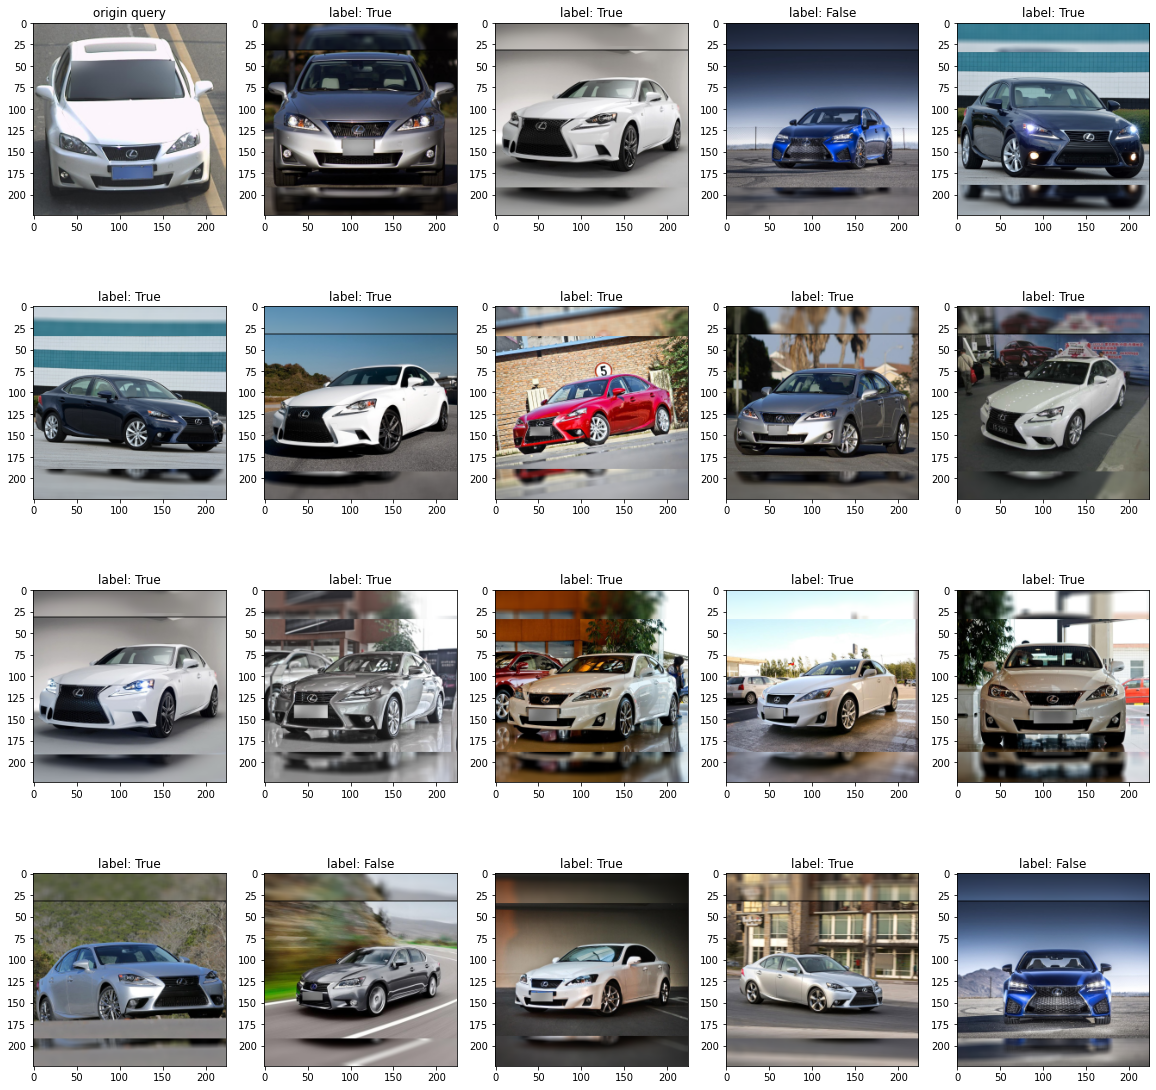

In [14]:
show_retrieved_query(15881, isValid=False)